In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 13s 158ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 2/50
53/53 [==============================] - 7s 127ms/step - loss: 0.0993 - root_mean_squared_error: 0.3151 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2616
Epoch 3/50
53/53 [==============================] - 6s 121ms/step - loss: 0.0405 - root_mean_squared_error: 0.2013 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2326
Epoch 4/50
53/53 [==============================] - 7s 129ms/step - loss: 0.0335 - root_mean_squared_error: 0.1829 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2144
Epoch 5/50
53/53 [==============================] - 7s 132ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1957
Epoch 6/50
53/53 [==============================] - 7s 129ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508 - val_loss: 0.0322 - val

53/53 [==============================] - 7s 142ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 30/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 31/50
53/53 [==============================] - 7s 143ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 32/50
53/53 [==============================] - 7s 144ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1279
Epoch 33/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1295
Epoch 34/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0168 - val_root_mean

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.072508172194163 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

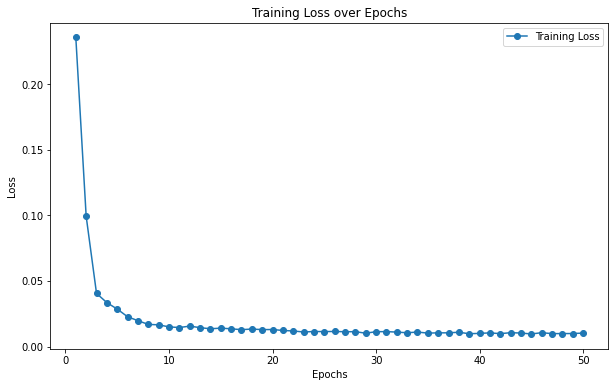

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

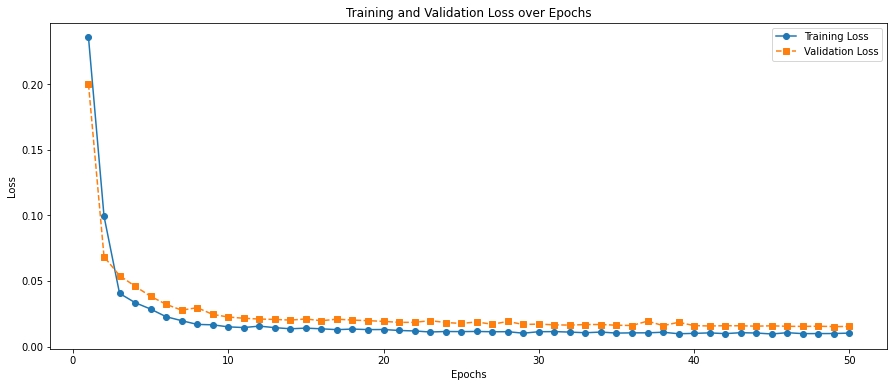

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 11ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10300481533762064
MAE : 0.08417168402659397


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.763997e+06,1575894.445
1,2.070828e+06,1714381.703
2,2.226955e+06,2067343.547
3,2.268577e+06,1856673.675
4,2.098575e+06,1914289.680
5,1.819507e+06,1802244.842
6,1.429788e+06,1202791.069
7,8.151516e+05,752834.272
8,5.136738e+05,451914.219
9,5.891588e+05,439855.813


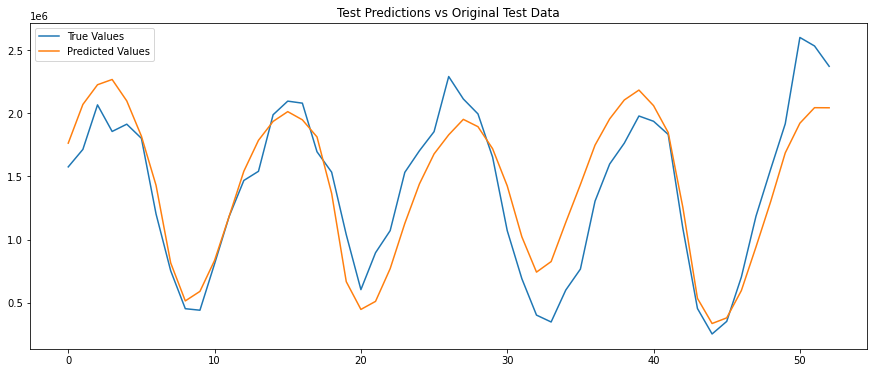

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

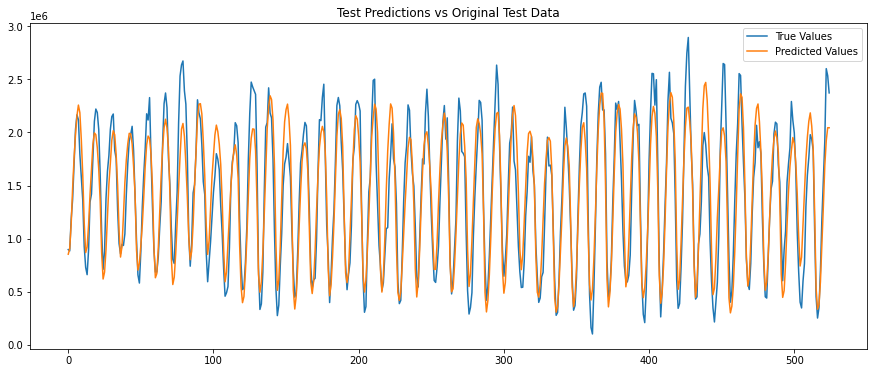

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()